# Kaggle - TMDB

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import math

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score

### Original language

Dictionaries taken from `tmdb-extract-tables-log`

In [5]:
l_short = {'en': 'en',
 'fr': 'fr',
 'ru': 'ru',
 'es': 'es',
 'hi': 'hi',
 'ja': 'ja',
 'it': 'it',
 'ko': 'ko',
 'cn': 'cn',
 'zh': 'zh',
 'de': 'de',
 'ta': 'ta'}

In [6]:
l_rev = {'en': 16.201695631547217,
 'fr': 13.718204235553607,
 'ru': 13.815132182879807,
 'es': 14.645970166012837,
 'hi': 15.371121660763546,
 'ja': 15.818050019285394,
 'it': 14.610307296701814,
 'ko': 14.561503498231747,
 'cn': 15.720496475312752,
 'zh': 15.246036823468886,
 'de': 14.583008872938295,
 'ta': 15.073328869838628}

In [9]:
train['l_short'] = train['original_language'].map(l_short).fillna('other')

In [10]:
train['l_rev'] = train['original_language'].map(l_rev).fillna(13.61844005781211)

In [37]:
# build dummy variables (skip 'other' as default)
for l in l_rev.keys():
    train[l] = train['l_short'].map(lambda x: 1 if x==l else 0)

In [41]:
coll_language = [l for l in l_rev.keys()]

### Collection

In [4]:
train['coll_id'] = train['belongs_to_collection'].fillna('[{"id":0}]').map(lambda x: (ast.literal_eval(x))[0]['id'])

In [11]:
colls = pd.read_csv('collections.csv',index_col=0)
colls.head()

,average_of_logs,log_of_averages
10,20.426152,20.435183
84,20.028003,20.090780
119,20.616135,20.616602
151,18.351379,18.387469
230,19.025411,19.067345


In [12]:
train['coll_rev_avlog'] = train['coll_id'].map(colls['average_of_logs']).fillna(0)
train['coll_rev_logav'] = train['coll_id'].map(colls['log_of_averages']).fillna(0)

In [13]:
reg = LinearRegression()
boost = GradientBoostingRegressor()

### Add genres

In [14]:
genres = pd.read_csv('genres.csv',index_col=0)
genres.head()

,name,log_revenue
10752,War,16.136653
10402,Music,15.676485
35,Comedy,16.086749
99,Documentary,12.532945
37,Western,15.344659


**As dummy variables**

In [13]:
genres.index

Int64Index([10752, 10402,    35,    99,    37,    36,    12,   878,    14,
               16,    80,    18,  9648, 10769,    53, 10770,    27,    28,
            10749, 10751],
           dtype='int64')

In [15]:
train['genres_id'] = train['genres'].fillna('[{"id":-1}]').map(lambda x: [i['id'] for i in (ast.literal_eval(x))])

In [16]:
# build dummy variables
for g in genres.index:
    name = f'genre_{g}'
    train[name] = train['genres_id'].map(lambda x: 1 if g in x else 0)

In [17]:
genre_cols = [f'genre_{g}' for g in genres.index]

**As mean of revenues**

In [18]:
gen_rev = dict(genres['log_revenue'])

In [22]:
null_mean = train[train['genres'].isnull()]['revenue'].map(math.log).mean()

In [24]:
gen_rev[-1] = null_mean

In [26]:
train['genre_ave'] = train['genres_id'].map(lambda x: np.array([gen_rev[g] for g in x]).mean())
train['genre_top'] = train['genres_id'].map(lambda x: np.array([gen_rev[g] for g in x]).max())

In [55]:
def consider_all(X):
    a = cross_val_score(reg,X,y,cv=10,scoring='neg_mean_squared_error').mean()
    b = cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()
    return (-a,-b)

**Select features**

In [43]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'coll_id', 'l_short', 'l_rev', 'coll_rev_avlog', 'coll_rev_logav',
       'genres_id', 'genre_10752', 'genre_10402', 'genre_35', 'genre_99',
       'genre_37', 'genre_36', 'genre_12', 'genre_878', 'genre_14', 'genre_16',
       'genre_80', 'genre_18', 'genre_9648', 'genre_10769', 'genre_53',
       'genre_10770', 'genre_27', 'genre_28', 'genre_10749', 'genre_10751',
       'genre_ave', 'genre_top', 'en', 'fr', 'ru', 'es', 'hi', 'ja', 'it',
       'ko', 'cn', 'zh', 'de', 'ta'],
      dtype='object')

To consider: budget, popularity, l_rev, coll_rev_avlog, coll_rev_logav, genre_cols, genre_ave, genre_top, coll_langauge

In [48]:
X = train[['budget']]
y = train['revenue'].map(math.log)

In [56]:
consider_all(X)

(7.223665461373166, 5.706974056774555)

In [57]:
X = train[['budget','popularity']]
consider_all(X)

(7.092864106338264, 5.179834132932621)

In [58]:
X = train[['budget','popularity','l_rev']]
consider_all(X)

(6.945186660497018, 5.120827714132824)

In [59]:
X = train[['budget','popularity','l_rev','coll_rev_avlog']]
consider_all(X)

(6.667949608594123, 4.558115611306467)

In [60]:
X = train[['budget','popularity','l_rev','coll_rev_avlog','coll_rev_logav']]
consider_all(X)

(6.664923850053823, 4.556403102189301)

In [61]:
X = train[['budget','popularity','l_rev','coll_rev_logav']]
consider_all(X)

(6.669515331520242, 4.563687067688598)

In [62]:
X = train[['budget','popularity','l_rev','coll_rev_avlog','coll_rev_logav',*genre_cols]]
consider_all(X)

(6.373205628515484, 4.619855879622176)

In [63]:
X = train[['budget','popularity','l_rev','coll_rev_avlog','coll_rev_logav',*genre_cols,'genre_ave']]
consider_all(X)

(6.374318899537425, 4.596555159988915)

In [65]:
X = train[['budget','popularity','l_rev',
           'coll_rev_avlog','coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(6.3810698447655705, 4.605284872188227)

In [68]:
X = train[['budget','popularity',
           'l_rev',*coll_language,
           'coll_rev_avlog','coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(6.452078025227118, 4.6401174493915995)

In [69]:
X = train[['budget','popularity',
           'coll_rev_avlog','coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(6.499493267671175, 4.639100649040976)

In [72]:
X = train[['budget','popularity',
           'l_rev',
           'coll_rev_avlog','coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(6.3810698447655705, 4.60025221827125)

In [73]:
X = train[['budget','popularity',
           *coll_language,
           'coll_rev_avlog','coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(6.452078024974031, 4.6097767426625795)

**l_rev seems to be best for the languages**

In [74]:
X = train[['budget','popularity',
           'l_rev',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(6.589264390422014, 5.027246523537057)

In [75]:
X = train[['budget','popularity',
           'l_rev',
           'coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(6.38100730555377, 4.59818395834103)

In [76]:
X = train[['budget','popularity',
           *coll_language,
           'coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(6.451892042012446, 4.660404908443061)

**coll_rev_logav is best for the collections**

In [77]:
X = train[['budget',
           'l_rev',
           'coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(6.449446799232923, 4.865131530470322)

In [78]:
X = train[['popularity',
           'l_rev',
           'coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(7.204343125401214, 5.666510094138614)

**Both populariy and budget help**

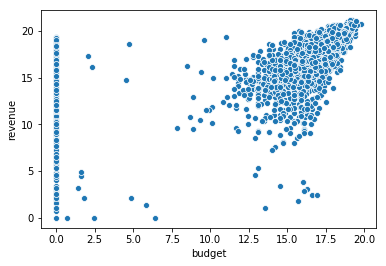

In [92]:
sns.scatterplot(x=train['budget'].map(lambda x: math.log(x) if x>0 else 0),y=train['revenue'].map(math.log))

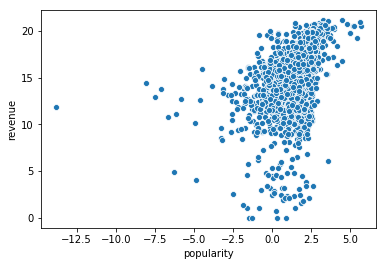

In [93]:
sns.scatterplot(x=train['popularity'].map(lambda x: math.log(x) if x>0 else 0),y=train['revenue'].map(math.log))

try with popularity and budget logged as well

In [94]:
train['log_pop'] = train['popularity'].map(lambda x: math.log(x) if x>0 else 0)
train['log_budget'] = train['budget'].map(lambda x: math.log(x) if x>0 else 0)

In [96]:
X = train[['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(6.381007305552918, 4.594943589489231)

In [97]:
X = train[['popularity','log_budget',
           'l_rev',
           'coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(6.04215209512376, 4.769551463285117)

In [98]:
X = train[['log_pop','log_budget',
           'l_rev',
           'coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(5.52468186045258, 4.768020326297168)

In [100]:
X = train[['log_pop','budget',
           'l_rev',
           'coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(5.7253344119284275, 4.5995120060586085)

Doesn't help<br>
best so far:

In [101]:
X = train[['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           *genre_cols,'genre_ave','genre_top']]
consider_all(X)

(6.381007305552918, 4.594925724450286)

In [102]:
X = train[['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           *genre_cols,'genre_ave']]
consider_all(X)

(6.374159994077006, 4.616635583525324)

In [103]:
X = train[['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           *genre_cols,'genre_top']]
consider_all(X)

(6.378371475660025, 4.567045866168271)

In [104]:
X = train[['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave','genre_top']]
consider_all(X)

(6.4330122260134885, 4.552293266497074)

In [105]:
X = train[['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_top']]
consider_all(X)

(6.562263547598269, 4.559214064167132)

In [106]:
X = train[['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave']]
consider_all(X)

(6.456803321716821, 4.536470306675909)

In [107]:
X = train[['popularity','budget',
           'l_rev',
           'coll_rev_logav'
           ]]
consider_all(X)

(6.66951533152024, 4.562513794730135)

**Only 'genre_ave' for genres**

Final:

In [108]:
X = train[['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave']]
consider_all(X)

(6.456803321716821, 4.533753485271082)

Expected score on kaggle:

In [109]:
np.sqrt(consider_all(X))

array([2.54102407, 2.12874957])

In [110]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'coll_id', 'l_short', 'l_rev', 'coll_rev_avlog', 'coll_rev_logav',
       'genres_id', 'genre_10752', 'genre_10402', 'genre_35', 'genre_99',
       'genre_37', 'genre_36', 'genre_12', 'genre_878', 'genre_14', 'genre_16',
       'genre_80', 'genre_18', 'genre_9648', 'genre_10769', 'genre_53',
       'genre_10770', 'genre_27', 'genre_28', 'genre_10749', 'genre_10751',
       'genre_ave', 'genre_top', 'en', 'fr', 'ru', 'es', 'hi', 'ja', 'it',
       'ko', 'cn', 'zh', 'de', 'ta', 'log_pop', 'log_budget'],
      dtype='object')

### Test set

In [34]:
# collection
test['coll_id'] = test['belongs_to_collection'].fillna('[{"id":0}]').map(
    lambda x: (ast.literal_eval(x))[0]['id'])
test['coll_rev'] = test['coll_id'].map(colls['average_revenue']).fillna(0)
# genres
test['genres_id'] = test['genres'].fillna('[{"id":-1}]').map(
    lambda x: [i['id'] for i in (ast.literal_eval(x))])
for g in genres.index:
    name = f'genre_{g}'
    test[name] = test['genres_id'].map(lambda x: 1 if g in x else 0)

In [35]:
test['genre_ave'] = test['genres_id'].map(lambda x: np.array([gen_rev[g] for g in x]).mean())
test['genre_top'] = test['genres_id'].map(lambda x: np.array([gen_rev[g] for g in x]).max())

In [36]:
T_ave  = test[['budget','popularity','coll_rev','genre_ave']].values
T_top  = test[['budget','popularity','coll_rev','genre_top']].values
T_both = test[['budget','popularity','coll_rev','genre_ave','genre_top']].values

In [37]:
submit = pd.read_csv('sample_submission.csv',index_col='id')
submit.head()

,revenue
id,
3001,1000000
3002,1000000
3003,1000000
3004,1000000
3005,1000000


In [41]:
y = np.log(y)
boost.fit(X_ave,y)
pred = boost.predict(T_ave)

#submit['revenue'] = pred
#submit.to_csv('log_ave_gen.csv')

In [50]:
pred = np.exp(pred)

In [51]:
submit['revenue'] = pred
submit.to_csv('log_ave_gen.csv')
### note that the avereages are not logged

In [48]:
np.log(12314651)

16.32630024971174

In [49]:
np.exp(y[0])

12314651.000000002